# Sentiment Analysis for IMF's Technical Assistance Reports 

Data: this analysis uses only publicly available reports. Pdf files can be downloaded directly from the IMF website.

## Data Prep

In [1]:
import pickle
import gensim
import numpy as np
import nltk
import re
import pandas as pd
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize,sent_tokenize
import seaborn as sns
import matplotlib.pyplot as plt
%reload_ext Cython

In [2]:
with open('TA_processed_xml.p', 'rb') as f:
    TA_all_data = pickle.load(f)

In [3]:
len(TA_all_data)

70

In [4]:
#Function to create a dataframe from a document object
def create_df_from_doc_obj(doc_obj):
    df = pd.DataFrame({'doc_seriesNo': doc_obj.series_id,
                       'doc_PublisherId': doc_obj.PublisherId,
                        'Country': doc_obj.country,
                         'Year': doc_obj.ProjectedYear,
                        'Para_id': range(len(doc_obj.paras)),
                        'Paragraph': doc_obj.paras})
    df = df[['doc_seriesNo','doc_PublisherId','Country','Year','Para_id','Paragraph']]
    
    return df

In [5]:
test_df = create_df_from_doc_obj(TA_all_data[113])

In [6]:
test_df.head()

,doc_seriesNo,doc_PublisherId,Country,Year,Para_id,Paragraph
0,113,24415-9781484307489_A001_002,Botswana,2018,0,1. Public investment has been a key element of...
1,113,24415-9781484307489_A001_002,Botswana,2018,1,2. Despite a high dependency on mineral revenu...
2,113,24415-9781484307489_A001_002,Botswana,2018,2,"3. By 2015, public spending ratios in Botswana..."
3,113,24415-9781484307489_A001_002,Botswana,2018,3,4. Consistent with relatively high public inve...
4,113,24415-9781484307489_A001_002,Botswana,2018,4,5. Botswana’s public investment is quite volat...


In [7]:
#Combine all document objects into one dataframe
TA_df = pd.DataFrame()
for doc in TA_all_data:
    df = create_df_from_doc_obj(TA_all_data[doc])
    TA_df = TA_df.append(df)

In [8]:
len(set(TA_df.doc_seriesNo))

70

In [9]:
TA_df.groupby('Year')['Country'].nunique()

Year
2006     1
2010     1
2012     1
2013     7
2014     7
2015     6
2016    16
2017    12
2018     3
Name: Country, dtype: int64

In [10]:
TA_df.groupby('Country')['Year'].nunique()

Country
Bhutan                                      1
Botswana                                    3
Bulgaria                                    1
Colombia                                    1
Denmark                                     1
Estonia                                     1
Finland                                     1
Gambia, The;Malawi;Uganda;Tanzania;Ghana    1
Georgia                                     1
Guatemala                                   1
Hungary                                     2
Iceland                                     3
Israel                                      2
Italy                                       2
Jamaica                                     1
Japan                                       1
Kosovo                                      2
Libyan  Arab Jamahiriya                     1
Macedonia, former Yugoslav Republic of      1
Malawi                                      1
Malaysia                                    1
Mali                      

## Method 1: Using a list of positive and negative vocabulary

1. Search negative and positive words in each paragraph of a document
2. Negate positive words within 3 words of negative words ('not','no','nobody','none','never','neither','cannot')
3. Do not negate negative words
4. Calculate a sentiment index by country and period:
        index = (#Positive words - #Negative words) / #Total words


Reference: 
Correa, Ricardo, Keshav Garud, Juan M. Londono, and
Nathan Mislang (2017). Sentiment in Central Banks’ Financial
Stability Reports. International Finance Discussion Papers 1203. 

In [11]:
sentiment_words = pd.read_csv('sentiment_words.csv')

In [12]:
pos_words = [word for word in sentiment_words.pos if isinstance(word, str) ]
neg_words = [word for word in sentiment_words.neg if isinstance(word, str) ]

In [13]:
pos_words_1 = ['\\b'+word+'\\b' for word in pos_words] #to find exact words
neg_words_1 = ['\\b'+word+'\\b' for word in neg_words]

pos_pattern = '|'.join(pos_words_1)
neg_pattern = '|'.join(neg_words_1)

In [14]:
TA_df['No_pos_words'] = TA_df.Paragraph.apply(lambda para: len(re.findall(pos_pattern, para, flags=re.IGNORECASE)))
TA_df['No_neg_words'] = TA_df.Paragraph.apply(lambda para: len(re.findall(neg_pattern, para, flags=re.IGNORECASE)))

In [15]:
from nltk.corpus import stopwords

negation_list = ['not','no','nobody','none','never','neither','cannot']

stopw = stopwords.words('english')
stopw = [s for s in stopw if s not in negation_list]
lemmatizer = WordNetLemmatizer()


#Function to get a list of 3 words before and after the keyword
def get_words_to_check_negation(words, idx, ran = 3):
    sent_length = len(words)
    nidx = [idx-ran, idx+ran]
    if nidx[0]<0: nidx[0]= 0
    if nidx[1] >sent_length+1: nidx[1] = sent_length+1
    negation_checklist = words[nidx[0]: nidx[1]]
    return negation_checklist


#Function to count number of positive words and negative words in a paragraph
def count_pos_neg_words(paragraph, negation_list):
    #1. Tokenize sentence:
    sent = sent_tokenize(paragraph)
    #2. Tokenize words in a sentence and calculate positive and negative words:
    pos = 0
    neg = 0
    for s in sent:
        words = word_tokenize(s.lower())
        for idx, w in enumerate(words):
            if w in pos_words:               
                negation_check = get_words_to_check_negation(words, idx, 3)
                list_negation = [t for t in negation_check if t in negation_list]
                if len(list_negation) == 0: pos+=1
                else: neg+=1
            elif w in neg_words:
                neg+=1
    return pos, neg

#Function to get the count of tokens in a paragraph
def count_number_of_tokens(paragraph, negation_list, lemmatizer, stopw):
    tokens = word_tokenize(paragraph.lower())
    tokens = [t for t in tokens if t.isalpha()] #to eliminate non characters
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    tokens = [t for t in tokens if t not in stopw]
    return len(tokens)

In [16]:
TA_df['sentiment'] = TA_df.Paragraph.apply(lambda para: 
                                           count_pos_neg_words(para,negation_list))
TA_df['total_tokens'] = TA_df.Paragraph.apply(lambda para: 
                                              count_number_of_tokens(para,negation_list, lemmatizer, stopw))
TA_df[['sentiment_pos','sentiment_neg']] = TA_df.sentiment.apply(pd.Series)

In [17]:
TA_df.head()

,doc_seriesNo,doc_PublisherId,Country,Year,Para_id,Paragraph,No_pos_words,No_neg_words,sentiment,total_tokens,sentiment_pos,sentiment_neg
0,1536,22840-9781513535890_A001_002,Malaysia,2016,0,1. Malaysia’s economy has performed strongly s...,0,0,"(0, 0)",21,0,0
1,1536,22840-9781513535890_A001_002,Malaysia,2016,1,2. The government has a clear vision for Malay...,1,0,"(1, 0)",41,1,0
2,1536,22840-9781513535890_A001_002,Malaysia,2016,2,"To achieve these goals, the plan set out five ...",0,1,"(0, 1)",46,0,1
3,1536,22840-9781513535890_A001_002,Malaysia,2016,3,3. Prudent fiscal management plays an importan...,3,0,"(3, 0)",35,3,0
4,1536,22840-9781513535890_A001_002,Malaysia,2016,4,4. As part of its strategy for prudent fiscal ...,0,0,"(0, 0)",38,0,0


In [18]:
print(TA_df.loc[TA_df.No_pos_words != TA_df.sentiment_pos].shape)
print(TA_df.loc[TA_df.No_pos_words > TA_df.sentiment_pos].shape)

(187, 12)
(187, 12)


In [19]:
#Check discrepancy between No_pos_words and sentiment_pos:
test_1 = TA_df.iloc[173,5]
tokens = word_tokenize(test_1.lower())
tokens = [t for t in tokens if t.isalpha()] #to eliminate non characters
tokens = [lemmatizer.lemmatize(t) for t in tokens]
tokens = [t for t in tokens if t not in stopw]

print ('Paragraph:',test_1)
print ('\nClean bag of words:', tokens)
print ('\nWords that re.findall function found: \nPositive:',
       re.findall(pos_pattern, test_1, flags=re.IGNORECASE),
       '\nNegative:', re.findall(neg_pattern, test_1,flags=re.IGNORECASE))

Paragraph: 133. The Performance and Evaluation Sector should lead the effort to introduce guidance for ministries, departments, and agencies on conducting program evaluations. Evaluation is applied sporadically in government and therefore does not adequately inform planning, policy-making, and budgeting. As a result there are often missed opportunities to improve the relevance, effectiveness, efficiency, impact, and sustainability of government programs. Evaluation is a type of applied research that attempts to identify cause-effect relationships within a specific context. In this report evaluation is defined as the systematic collection and objective analysis of evidence on public policies, programs, projects, functions and organizations to assess issues such as performance, value for money, impact and sustainability, and recommend opportunities for improvements.

Clean bag of words: ['performance', 'evaluation', 'sector', 'lead', 'effort', 'introduce', 'guidance', 'ministry', 'depart

In [20]:
TA_unique_df = TA_df.groupby(['Country','Year'], 
                             as_index = False)['sentiment_pos',
                                               'sentiment_neg',
                                                'total_tokens'].sum()

TA_unique_df['sentiment_index'] = (TA_unique_df.sentiment_pos - TA_unique_df.sentiment_neg)/TA_unique_df.total_tokens

In [21]:
print(TA_unique_df.shape)
TA_unique_df.head()

(54, 6)


,Country,Year,sentiment_pos,sentiment_neg,total_tokens,sentiment_index
0,Bhutan,2014,98,26,4830,0.014907
1,Botswana,2015,91,69,9289,0.002368
2,Botswana,2017,79,130,7617,-0.006696
3,Botswana,2018,42,51,5306,-0.001696
4,Bulgaria,2016,31,23,3466,0.002308


In [22]:
TA_unique_df.loc[TA_unique_df['Country']=='Iceland']

,Country,Year,sentiment_pos,sentiment_neg,total_tokens,sentiment_index
14,Iceland,2012,58,56,10366,0.000193
15,Iceland,2015,99,67,13291,0.002408
16,Iceland,2016,119,41,7301,0.010683


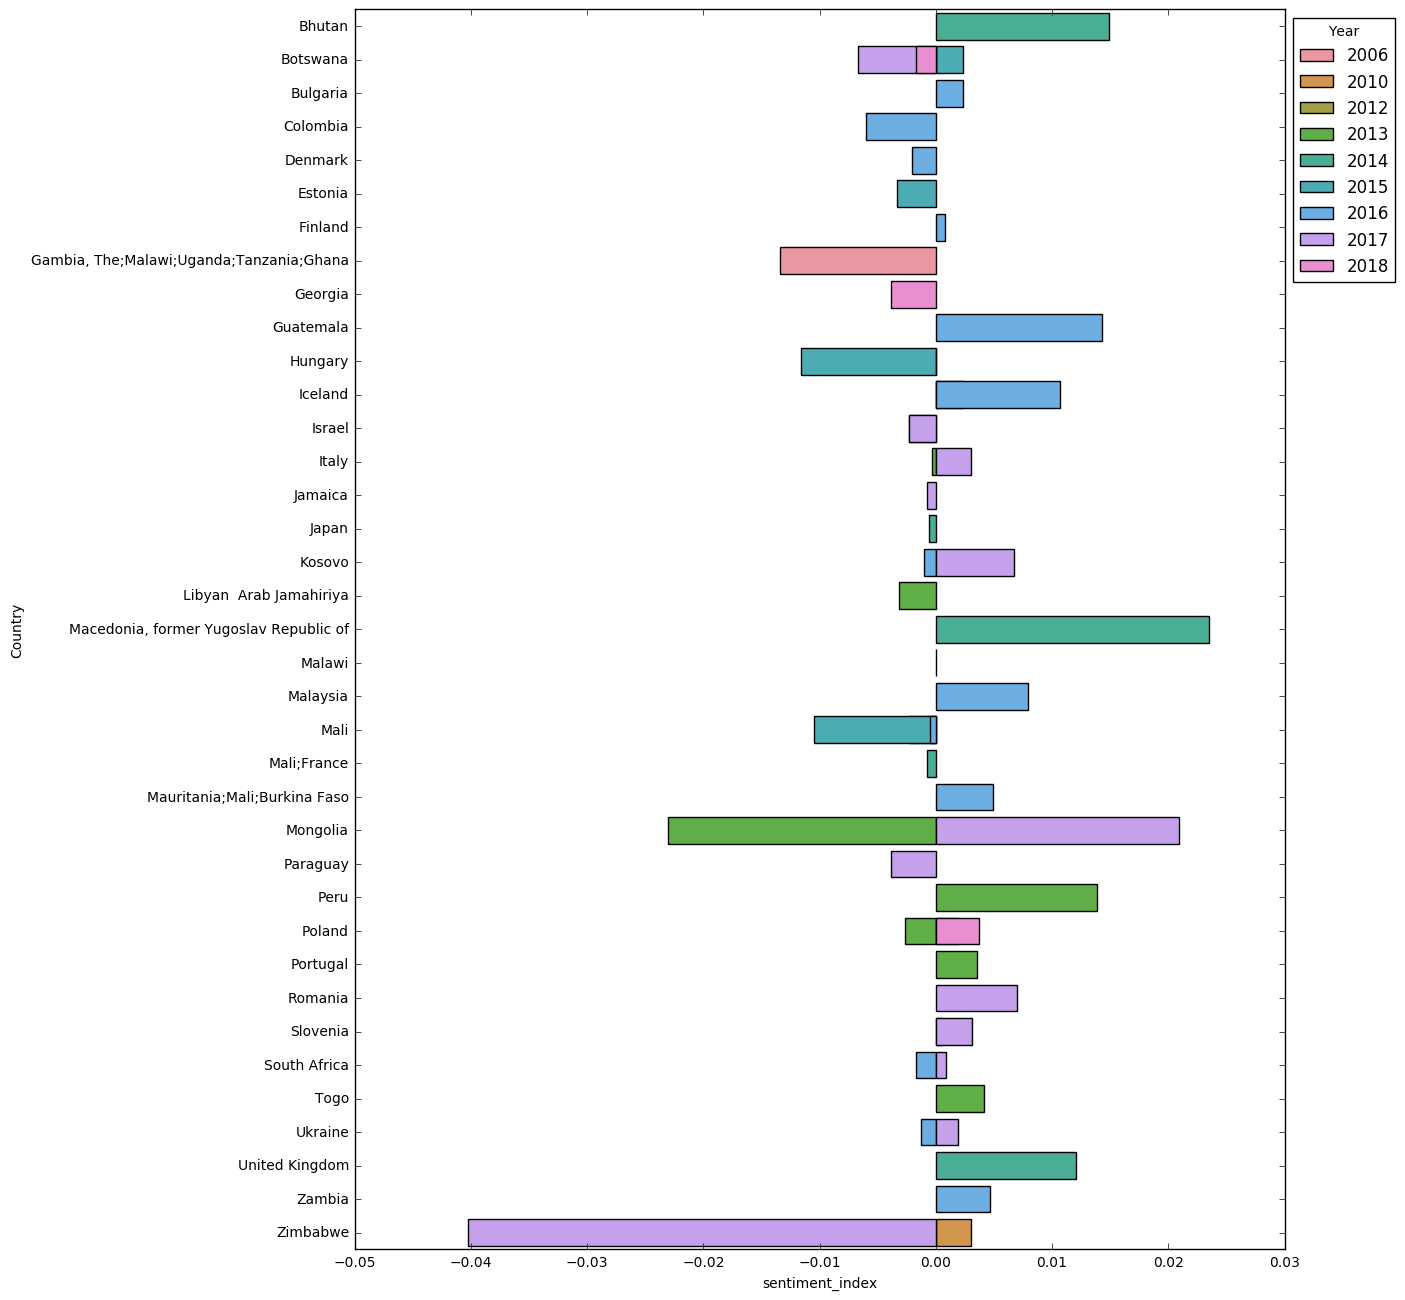

In [23]:
plt.figure(figsize=(12,16))
sns.barplot(x = 'sentiment_index', y= 'Country',hue = 'Year', data = TA_unique_df, dodge=False)
plt.legend(title = 'Year', loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

## Method 2: Using sentiment labeled financial news 

### Overview of training datasets

##### Dataset 1: Economic News Article Tone and Relevance

Contributors read snippets of news articles. They then noted if the article was relevant to the US economy and, if so, what the tone of the article was. Tone was judged on a 9 point scale (from 1 to 9, with 1 representing the most negativity). Dataset contains these judgments as well as the dates, source titles, and text. Dates range from 1951 to 2014.

Added: December 8, 2015 by CrowdFlower | Data Rows: 8000



In [24]:
labeled_news = pd.read_csv('Full-Economic-News-DFE-839861.csv',encoding = 'ISO-8859-1')

In [25]:
labeled_news.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,positivity,positivity:confidence,relevance,relevance:confidence,articleid,date,headline,positivity_gold,relevance_gold,text
0,842613455,False,finalized,3,12/5/15 17:48,3.0,0.6400,yes,0.640,wsj_398217788,8/14/91,Yields on CDs Fell in the Latest Week,NaN,NaN,NEW YORK -- Yields on most certificates of dep...
1,842613456,False,finalized,3,12/5/15 16:54,NaN,NaN,no,1.000,wsj_399019502,8/21/07,The Morning Brief: White House Seeks to Limit ...,NaN,NaN,The Wall Street Journal Online</br></br>The Mo...
2,842613457,False,finalized,3,12/5/15 1:59,NaN,NaN,no,1.000,wsj_398284048,11/14/91,Banking Bill Negotiators Set Compromise --- Pl...,NaN,NaN,WASHINGTON -- In an effort to achieve banking ...
3,842613458,False,finalized,3,12/5/15 2:19,NaN,0.0000,no,0.675,wsj_397959018,6/16/86,Manager's Journal: Sniffing Out Drug Abusers I...,NaN,NaN,The statistics on the enormous costs of employ...
4,842613459,False,finalized,3,12/5/15 17:48,3.0,0.3257,yes,0.640,wsj_398838054,10/4/02,Currency Trading: Dollar Remains in Tight Rang...,NaN,NaN,NEW YORK -- Indecision marked the dollar's ton...


In [26]:
train_data1 = labeled_news.loc[labeled_news.relevance == 'yes']

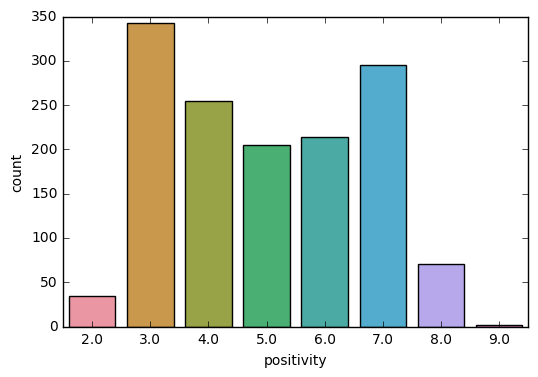

In [27]:
sns.countplot(train_data1.positivity)
plt.show()

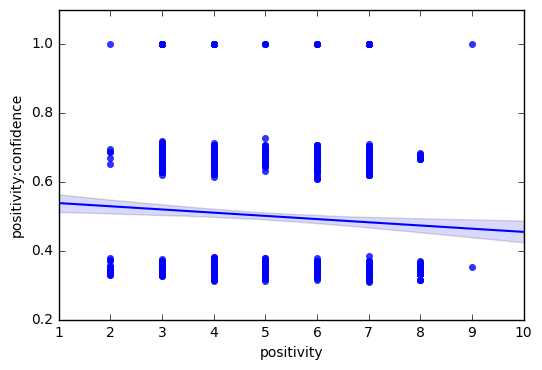

In [28]:
sns.regplot(x='positivity', y = 'positivity:confidence', data = train_data1)
plt.show()

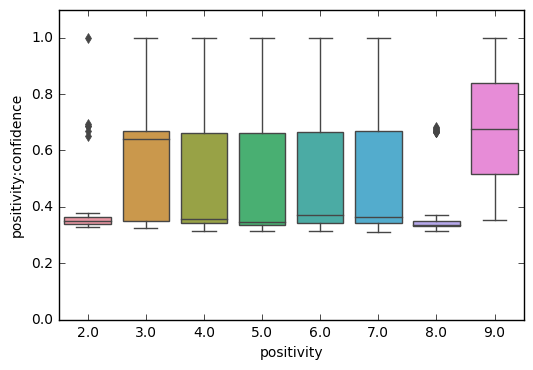

In [29]:
sns.boxplot(x = 'positivity', y = 'positivity:confidence', data = train_data1 )
plt.ylim(0, 1.1)
plt.show()

In [30]:
train_data1 = train_data1[['text','positivity','positivity:confidence']]

##### Dataset 2: U.S. economic performance based on news articles

Contributors viewed a new article headline and a short, bolded excerpt of a sentence or two from the attendant article. Next, they decided if the sentence in question provided an indication of the U.S. economyâ€™s health, then rated the indication on a scale of 1-9, with 1 being negative and 9 being positive.

Added: June 25, 2015 by CrowdFlower | Data Rows: 5000

In [31]:
labeled_news1 = pd.read_csv('us-economic-newspaper.csv',encoding = 'ISO-8859-1')

In [32]:
train_data2 = labeled_news1.loc[labeled_news1.relevance == 'yes']

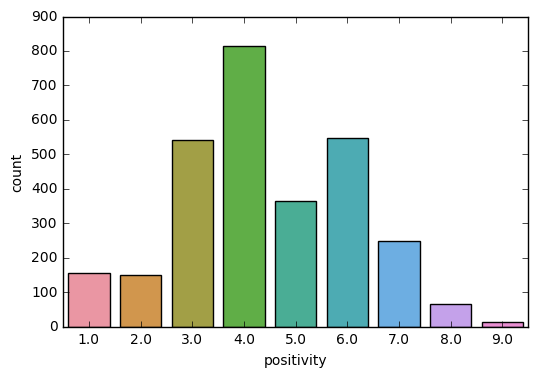

In [33]:
sns.countplot(train_data2.positivity)
plt.show()

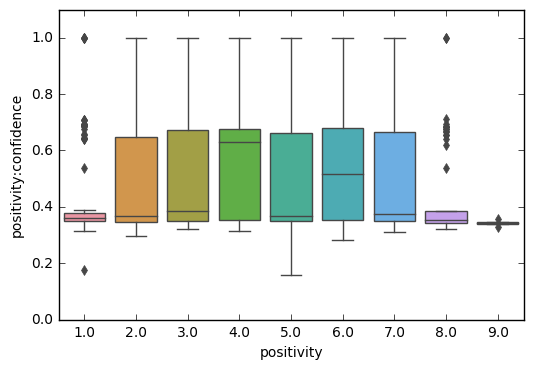

In [34]:
sns.boxplot(x = 'positivity', y = 'positivity:confidence', data = train_data2 )
plt.ylim(0, 1.1)
plt.show()

In [35]:
train_data2 = train_data2[['text','positivity','positivity:confidence']]

Merging 2 training datasets

In [36]:
train_data = pd.concat([train_data1, train_data2])

In [37]:
train_data.head()

,text,positivity,positivity:confidence
0,NEW YORK -- Yields on most certificates of dep...,3.0,0.6400
4,NEW YORK -- Indecision marked the dollar's ton...,3.0,0.3257
5,"Stocks declined, as investors weighed slower-t...",3.0,0.6783
9,The U.S. dollar declined against most major fo...,4.0,0.6657
12,Author: James B. Stewart</br></br>The dreaded ...,4.0,0.3388


In [38]:
# Drop missing values
train_data.dropna(inplace=True)
print (train_data.shape)

(4319, 3)


In [39]:
# Remove any 'neutral' ratings equal to 5
train_data = train_data.loc[train_data['positivity'] != 5]

# Encode 6-9s as 1 (rated positively)
# Encode 1-4s as 0 (rated poorly)
train_data['Positively Rated'] = np.where(train_data['positivity'] > 5, 1, 0)
train_data.head(10)

,text,positivity,positivity:confidence,Positively Rated
0,NEW YORK -- Yields on most certificates of dep...,3.0,0.6400,0
4,NEW YORK -- Indecision marked the dollar's ton...,3.0,0.3257,0
5,"Stocks declined, as investors weighed slower-t...",3.0,0.6783,0
9,The U.S. dollar declined against most major fo...,4.0,0.6657,0
12,Author: James B. Stewart</br></br>The dreaded ...,4.0,0.3388,0
17,"NEW YORK -- The dollar sagged yesterday, as ne...",3.0,0.6422,0
20,"The technology industry, an engine of innovati...",7.0,0.6207,1
21,WASHINGTON -- While acknowledging that the pac...,6.0,0.3571,1
27,WASHINGTON -- In a sign that inflation remains...,6.0,0.3478,1
30,WASHINGTON -- Consumer credit in July continue...,6.0,0.3504,1


In [40]:
#The numbers of positive rating and negative rating are quite even
train_data['Positively Rated'].mean()

0.3888

### Bag of Words Approach 



In [41]:
from bs4 import BeautifulSoup  

# Initialize the BeautifulSoup object on a single news   
example1 = BeautifulSoup(train_data['text'][0], 'lxml')  

# Print the raw review and then the output of get_text(), for 
# comparison
print (train_data['text'][0])
print (example1.get_text())


NEW YORK -- Yields on most certificates of deposit offered by major banks dropped more than a tenth of a percentage point in the latest week, reflecting the overall decline in short-term interest rates.</br></br>On small-denomination, or "consumer," CDs sold directly by banks, the average yield on six-month deposits fell to 5.49% from 5.62% in the week ended yesterday, according to an 18-bank survey by Banxquote Money Markets, a Wilmington, Del., information service.</br></br>On three-month "consumer" deposits, the average yield sank to 5.29% from 5.42% the week before, according to Banxquote. Two banks in the Banxquote survey, Citibank in New York and CoreStates in Pennsylvania, are paying less than 5% on threemonth small-denomination CDs.</br></br>Declines were somewhat smaller on five-year consumer CDs, which eased to 7.37% from 7.45%, Banxquote said.</br></br>Yields on three-month and six-month Treasury bills sold at Monday's auction plummeted more than a fifth of a percentage poin

In [42]:
def process_text( raw_news, lemmatizer, stopw ):
    '''
    Function to convert a raw news to a string of words
    The input is a single string (a raw news), and 
    the output is a single string (a preprocessed news)
    '''
    from bs4 import BeautifulSoup  
    
    # Remove HTML
    news_text = BeautifulSoup(raw_news,"lxml").get_text() 

    # Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", news_text) 
    # Tokenize and clean bag of words:
    tokens = word_tokenize(letters_only.lower())
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    tokens = [t for t in tokens if t not in stopw]
    tokens = [t for t in tokens if len(t)>1]
    
    return( " ".join( tokens ))   



In [43]:
process_text(train_data['text'][0], lemmatizer, stopw)

'new york yield certificate deposit offered major bank dropped tenth percentage point latest week reflecting overall decline short term interest rate small denomination consumer cd sold directly bank average yield six month deposit fell week ended yesterday according bank survey banxquote money market wilmington del information service three month consumer deposit average yield sank week according banxquote two bank banxquote survey citibank new york corestates pennsylvania paying le threemonth small denomination cd decline somewhat smaller five year consumer cd eased banxquote said yield three month six month treasury bill sold monday auction plummeted fifth percentage point previous week respectively'

In [44]:
#Apply this to the dataframe
train_data['processed_text'] = train_data['text'].apply(lambda t: process_text(t, lemmatizer, stopw))

In [45]:
train_data.head()

,text,positivity,positivity:confidence,Positively Rated,processed_text
0,NEW YORK -- Yields on most certificates of dep...,3.0,0.6400,0,new york yield certificate deposit offered maj...
4,NEW YORK -- Indecision marked the dollar's ton...,3.0,0.3257,0,new york indecision marked dollar tone trader ...
5,"Stocks declined, as investors weighed slower-t...",3.0,0.6783,0,stock declined investor weighed slower expecte...
9,The U.S. dollar declined against most major fo...,4.0,0.6657,0,dollar declined major foreign currency yesterd...
12,Author: James B. Stewart</br></br>The dreaded ...,4.0,0.3388,0,author james stewartthe dreaded word back circ...


In [139]:
from sklearn.model_selection import train_test_split

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(train_data['processed_text'], 
                                                    train_data['Positively Rated'], 
                                                    random_state=4)

In [143]:
print('X_train first entry:\n\n', X_train.iloc[0])
print('\n\nX_train shape: ', X_train.shape)

X_train first entry:

 cincinnati executive daniel meyer newly named president cincinnati milacron inc dollar sharp plunge may bring opportunity lower dollar tends help capital good maker like milacron compete world market also generates business certain manufacturer fare better world competition dollar drop may kill stock market cause kind havoc put better competitive position world market mr meyer say optimistically trick cincinnati milacron transfer present know metal part manufacturing factory automation related business world wide growth mr meyer former executive vice president chief financial officer assignment profitably putting finance man president clear signal company emphasize profitability say eli lustgarten machinery analyst painewebber inc board wanted somebody le emotionally tied operation take hard look cost eliminated mr meyer indiana native ha worked milacron since say ha already begun cost cutting scrutiny whole cost structure review right say promotion followed imme

#### CountVectorizer

In [48]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score

# Fit the CountVectorizer to the training data
vect = CountVectorizer().fit(X_train)
print ('Number of features:',len(vect.get_feature_names()))

X_train_vectorized = vect.transform(X_train)
model = LogisticRegression().fit(X_train_vectorized, y_train)

predictions = model.predict(vect.transform(X_test))

print('AUC: ', roc_auc_score(y_test, predictions))

Number of features: 12494
AUC:  0.632996632997


In [49]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Accuracy = TP + TN / (TP + TN + FP + FN)
# Precision = TP / (TP + FP)
# Recall = TP / (TP + FN)  Also known as sensitivity, or True Positive Rate
# F1 = 2 * Precision * Recall / (Precision + Recall) 
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, predictions)))

Accuracy: 0.67
Precision: 0.55
Recall: 0.50
F1: 0.53


#### Tfidf

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Fit the TfidfVectorizer to the training data specifiying a minimum document frequency of 5
vect = TfidfVectorizer(min_df=5).fit(X_train)
print ('Number of features:',len(vect.get_feature_names()))

X_train_vectorized = vect.transform(X_train)

# Try Logistic Regression

model = LogisticRegression()
model.fit(X_train_vectorized, y_train)

predictions = model.predict(vect.transform(X_test))

print('AUC: ', roc_auc_score(y_test, predictions))

Number of features: 3375
AUC:  0.625288740114


In [51]:
# Try Support Vector Classification
# Grid-Search Approach
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

clf = SVC(kernel='linear')
grid_values = {'gamma': [0.001, 0.01, 0.05, 0.1, 1, 10, 100],
                'C': [0.001, 0.01, 0.05, 0.1, 1, 10, 100]}

# default metric to optimize over grid parameters: accuracy
grid_clf_acc = GridSearchCV(clf, param_grid = grid_values)
grid_clf_acc.fit(X_train_vectorized, y_train)
y_decision_fn_scores_acc = grid_clf_acc.decision_function(vect.transform(X_test)) 

print('Grid best parameter (max. accuracy): ', grid_clf_acc.best_params_)
print('Grid best score (accuracy): ', grid_clf_acc.best_score_)

# alternative metric to optimize over grid parameters: AUC
grid_clf_auc = GridSearchCV(clf, param_grid = grid_values, scoring = 'roc_auc')
grid_clf_auc.fit(X_train_vectorized, y_train)
y_predicted_scores_auc = grid_clf_auc.predict(vect.transform(X_test)) 

print('Test set AUC: ', roc_auc_score(y_test, y_predicted_scores_auc))
print('Grid best parameter (max. AUC): ', grid_clf_auc.best_params_)
print('Grid best score (AUC): ', grid_clf_auc.best_score_)

Grid best parameter (max. accuracy):  {'C': 1, 'gamma': 0.001}
Grid best score (accuracy):  0.644025604552
Test set AUC:  0.5
Grid best parameter (max. AUC):  {'C': 0.05, 'gamma': 0.001}
Grid best score (AUC):  0.668409541692


In [53]:
#Cross - Validation Approach

from sklearn.model_selection import cross_val_score

X, y = train_data['processed_text'], train_data['Positively Rated']
vect = TfidfVectorizer(min_df=5).fit(X)
X_vectorized = vect.transform(X)
clf = SVC(kernel='linear', C=1, gamma = 0.001)

# accuracy is the default scoring metric
print('Cross-validation (accuracy)', cross_val_score(clf, X_vectorized, y, cv=5))
# use AUC as scoring metric
print('Cross-validation (AUC)', cross_val_score(clf, X_vectorized, y, cv=5, scoring = 'roc_auc'))
# use recall as scoring metric
print('Cross-validation (recall)', cross_val_score(clf, X_vectorized, y, cv=5, scoring = 'recall'))

Cross-validation (accuracy) [ 0.60319574  0.66844208  0.64666667  0.64753004  0.65954606]
Cross-validation (AUC) [ 0.69400424  0.6862372   0.64311031  0.64468254  0.65558082]
Cross-validation (recall) [ 0.75        0.41780822  0.29109589  0.30584192  0.35395189]


In [56]:
# Apply the best C and gamma to the SVC model

clf = SVC(kernel='linear', C = 1, gamma = 0.001)
clf.fit(X_train_vectorized, y_train)

predictions = clf.predict(vect.transform(X_test))

print('AUC: ', roc_auc_score(y_test, predictions))

AUC:  0.632394683267


In [57]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Accuracy = TP + TN / (TP + TN + FP + FN)
# Precision = TP / (TP + FP)
# Recall = TP / (TP + FN)  Also known as sensitivity, or True Positive Rate
# F1 = 2 * Precision * Recall / (Precision + Recall) 
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, predictions)))

Accuracy: 0.69
Precision: 0.60
Recall: 0.43
F1: 0.50


### Word2Vec and Doc2Vec Approach 


In [524]:
%%cython
from gensim.models.keyedvectors import KeyedVectors

model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [525]:
model.most_similar(positive=['biggest','small'], negative=['big'], topn=5)

[('smallest', 0.6086567044258118),
 ('largest', 0.6007465720176697),
 ('tiny', 0.5387297868728638),
 ('large', 0.4569440186023712),
 ('minuscule', 0.434019535779953)]

#### Data Prep

In [109]:
def process_text_by_sent ( raw_news, lemmatizer, stopw ):
    '''
    Function to convert a raw news to clean sentences
    The input is a single string (a raw news), and 
    the output is a single string (a preprocessed news)
    '''
    from bs4 import BeautifulSoup  
    
    # Remove HTML
    news_text = BeautifulSoup(raw_news,"lxml").get_text() 

    #Clean numbers in the paragraph
    text = re.sub(r'\d+\,?\.?\d+','',news_text)
    
    #Split paragraph into sentence:
    sents = re.findall(r'[A-Z][a-z0-9].*?[a-z\s]\.',text)
    
    # Remove non-letters        
    letters_only = [re.sub("[^a-zA-Z]", " ", t) for t in sents]
    
    # Tokenize and clean bag of words:
    tokens = [word_tokenize(sent.lower()) for sent in letters_only]
    tokens = [[lemmatizer.lemmatize(t) for t in sent] for sent in tokens]
    tokens = [[t for t in sent if t not in stopw] for sent in tokens]
    tokens = [[t for t in sent if len(t)>1] for sent in tokens]
    
    return( [" ".join( sent ) for sent in tokens])   


In [112]:
process_text_by_sent(train_data['text'][0], lemmatizer, stopw)

['yield certificate deposit offered major bank dropped tenth percentage point latest week reflecting overall decline short term interest rate',
 'small denomination consumer cd sold directly bank average yield six month deposit fell week ended yesterday according bank survey banxquote money market wilmington del',
 'three month consumer deposit average yield sank week according banxquote',
 'two bank banxquote survey citibank new york corestates pennsylvania paying le threemonth small denomination cd',
 'decline somewhat smaller five year consumer cd eased banxquote said',
 'yield three month six month treasury bill sold monday auction plummeted fifth percentage point previous week respectively']

In [113]:
#Apply this to the dataframe
train_data['processed_sent'] = train_data['text'].apply(lambda t: process_text_by_sent(t, lemmatizer, stopw))

#### Train Word2Vec model

In [166]:
from gensim.models.word2vec import Word2Vec

def cleanText(text, by='sent'):
    if by=='sent':
        corpus = [x for para in text for x in para]
    else: corpus = text
    corpus = [z.split() for z in corpus]
    return corpus

x_train = cleanText(X_train, by=0)
x_test = cleanText(X_test, by = 0) 

n_dim = 200
#Initialize model and build vocab
finnews_w2v = Word2Vec(size=n_dim, window=10, min_count=5, workers=11,alpha=0.025, min_alpha=0.025)
finnews_w2v.build_vocab(x_train)

for epoch in range(10):
    token_count = sum([len(news) for news in x_train])
    finnews_w2v.train(x_train,total_examples = token_count,epochs=epoch)
    finnews_w2v.alpha -= 0.002 # decrease the learning rate
    finnews_w2v.min_alpha = finnews_w2v.alpha # fix the learning rate, no deca
    finnews_w2v.train(x_train,total_examples = token_count,epochs= epoch)
    
    


In [167]:
#Build word vector for training set by using the average value of all word vectors in the news, then scale
def buildWordVector(text, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in text:
        try:
            vec += finnews_w2v[word].reshape((1, size))
            count += 1.
        except KeyError:
            continue
    if count != 0:
        vec /= count
    return vec

In [168]:
from sklearn.preprocessing import scale
train_vecs = np.concatenate([buildWordVector(z, n_dim) for z in x_train])
train_vecs = scale(train_vecs)

#Train word2vec on test set
#token_count_test = sum([len(news) for news in x_test])
#finnews_w2v.train(x_test, total_examples = token_count_test, epochs=finnews_w2v.iter)

In [169]:
#Build test news vectors then scale
test_vecs = np.concatenate([buildWordVector(z, n_dim) for z in x_test])
test_vecs = scale(test_vecs)

In [174]:
# Try Logistic Regression

modellr = LogisticRegression()
modellr.fit(train_vecs, y_train)

predictions = modellr.predict_proba(test_vecs)[:,1]
exact_predict = modellr.predict(test_vecs)

print('AUC: ', roc_auc_score(y_test, predictions))
print('Accuracy: ', accuracy_score(y_test, exact_predict))

AUC:  0.652484143763
Accuracy:  0.642857142857


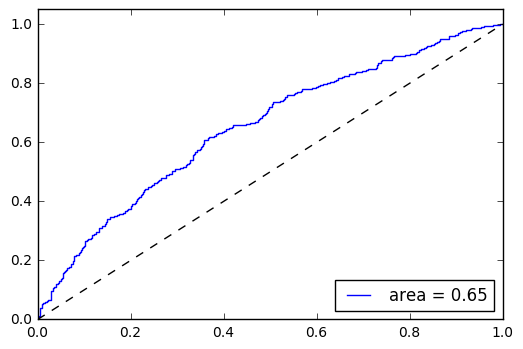

In [175]:
#Create ROC curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr,tpr,_ = roc_curve(y_test, predictions)
roc_auc = auc(fpr,tpr)
plt.plot(fpr,tpr,label='area = %.2f' %roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc='lower right')

plt.show()

### TextBlob Sentiment Analyzer

#### Using Naive Bayes Analyzer which was trained on a dataset of movie reviews 


Result: 
- Very slow (might takes hours to predict a small test dataset)
- Does not perform well with financial/ economic languages

In [176]:
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer

In [163]:
predict_TextBlob = []
for text in X_test:
    blob = TextBlob(text, analyzer = NaiveBayesAnalyzer())
    sent = blob.sentiment[0]
    if sent =='pos': predict_TextBlob.append(1)
    else: predict_TextBlob.append(0)

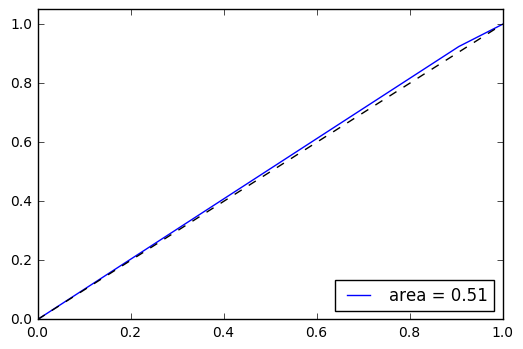

In [165]:
#Create ROC curve
fpr,tpr,_ = roc_curve(y_test, predict_TextBlob)
roc_auc = auc(fpr,tpr)
plt.plot(fpr,tpr,label='area = %.2f' %roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc='lower right')

plt.show()

#### Building a Text Classification System Using TextBlob

In [184]:
# Create training and test data

train_data['label'] = np.where(train_data['Positively Rated']==1, 'pos','neg')

from sklearn.model_selection import train_test_split

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(train_data['processed_text'], 
                                                    train_data['label'], 
                                                    random_state=4)

train = list(zip(X_train, y_train))
test = list(zip(X_test, y_test))

In [186]:
from textblob.classifiers import NaiveBayesClassifier
%time cl = NaiveBayesClassifier(train)

CPU times: user 33.7 s, sys: 2.9 s, total: 36.6 s
Wall time: 38.2 s


In [187]:
# Compute the accuracy of the classifier
%time cl.accuracy(test)

CPU times: user 2min 13s, sys: 12.2 s, total: 2min 26s
Wall time: 2min 33s


0.6343283582089553

In [189]:
cl.show_informative_features(10) 

Most Informative Features
          contains(fine) = True              pos : neg    =     12.7 : 1.0
       contains(upswing) = True              pos : neg    =     12.7 : 1.0
       contains(booming) = True              pos : neg    =      9.7 : 1.0
         contains(brisk) = True              pos : neg    =      9.7 : 1.0
 contains(corresponding) = True              pos : neg    =      9.7 : 1.0
        contains(behalf) = True              pos : neg    =      8.6 : 1.0
    contains(maintained) = True              pos : neg    =      8.6 : 1.0
   contains(legislation) = True              neg : pos    =      7.7 : 1.0
       contains(entered) = True              pos : neg    =      7.6 : 1.0
       contains(ongoing) = True              pos : neg    =      7.6 : 1.0
